# Huawei Research France

## Acrobot RAMP: system identification

### Forecast the state of the altered acrobot system from history and actions

_Balázs Kégl, Gabriel Hurtado, Jianfeng Zhang, Albert Thomas, Ludovic Dos Santos (Huawei Research, Noah's Ark Laboratory, France)_

<center>What is the probability that the world ends if I press this button?</center>

<img src="https://redstapler.co/wp-content/uploads/2019/07/chernobyl-az-5-button-css-real.jpg">

## Introduction


In recent year we have witnessed a phenomenal success of deep reinforcement learning algorithms beating top human players in [go](https://en.wikipedia.org/wiki/AlphaGo), [chess](https://en.wikipedia.org/wiki/AlphaZero) and even [poker](https://ai.facebook.com/blog/pluribus-first-ai-to-beat-pros-in-6-player-poker/). Why don't we see the widespread use of these algorithms in application domains half of the world is after, such as engineering system optimization or robotics? It turns out that one of the main conditions of these successes is the access to a simulator that can generate unlimited data to learn from.

_"The real world will not become faster in a few years, contrary to computers"_ ([Chatzilygeroudis et al. 2019](https://arxiv.org/pdf/1807.02303.pdf))

If we want to control engineering systems, we need to be able to learn to control them with limited access to data. In this regime, one of the promising directions is [model-based reinforcement learning](https://arxiv.org/abs/1907.02057). The main component of these algorithms is a learnable system model. Its objective is to learn to forecast system behavior, given past history and control actions.

Classical time series forecasting methods provide point predictions: "the minimum temperature tomorrow is 5 degrees Celsius". Without knowing the _certainty_ of the prediction, it is hard to train a controller, especially when extreme events need to be modeled ("OK, but what's the probability that the plants on my balcony will freeze?")

On the other hand, powerful and popular Bayesian forecasters do exist but they do not scale with either the length of the history or the system state dimensions.

**The goal of this challenge to develop sclaeable and powerful generative probabilistic time series forecasters.** We will provide you with training and testing traces from a physical system based on the [acrobot benchmark](https://gym.openai.com/envs/Acrobot-v1). We are challenging you to develop generic learning algorithms, so we made manual reverse engineering harder by changing the physics of the original system. 

### Formal task

You will be given a training multivariate time series ${\cal T} = \big[(o_t, a_t)\big]_{t=1}^T$ of observables $o_t \in \mathbb{R}^4$ and actions $a_t \in \{0, 1, 2\}$. You will need to learn to predict the density function of the observables at next step $o_{t+1}$, conditioned on the history:

\begin{equation}
  p\big(o_{t+1} | (o_1, a_1), \ldots, (o_t, a_t)\big).
\end{equation}

You will be evaluated on a test sequence ${\cal T}^\prime = \big[(o_t^\prime, a_t^\prime)\big]_{t=1}^{T^\prime}$ using the likelihood ratio

\begin{equation}
LR({\cal T}^\prime; p) = \frac{\prod_{t=1}^{T^\prime-1} p\big(o^\prime_{t+1} | (o^\prime_1, a^\prime_1), \ldots, (o^\prime_t, a^\prime_t)\big)}{L_\text{b}({\cal T}^\prime)},
\end{equation}

where $L_\text{b}({\cal T}^\prime)$ is a baseline (multivariate spherical Gaussian) likelihood.

${\cal T}$ and ${\cal T}^\prime$ will always come from the same dynamical system. However, to make manual reverse engineering hard, the time series in this public starting kit and the times series on the data challenge server will come from different physics, so your model should be prepared to be transferred to a (slightly) different system. 

We will keep the training set size the same, $T \simeq 5000$ in both the public and private training sets.

### Challenges
1. We do not know whether the system observables $o_t$ and action $a_t$ at time $t$ are sufficient to predict $o_{t+1}$. Therefore we will explicitly ask you to develop (or learn) a feature extractor $f_\text{FE}$ wich will convert the history up to time $t$ into a fixed length state vector $s_t$. Formally,
\begin{equation}
  s_t = f_\text{FE}\big((o_1, a_1), \ldots, (o_t, a_t)\big),
\end{equation}
and the predictor will then simplify to
\begin{equation}
  p\big(o_{t+1} | (o_1, a_1), \ldots, (o_t, a_t)\big) = p(o_{t+1} | s_t).
\end{equation}
2. The predictor $p(o_{t+1} | s_t)$ is not a classical regressor outputting a point estimate $\hat{o}_{t+1}$ but a $d$-dimensional density ($d=4$). We needed to find a numerical representation for such a function with two requirements: 1) computationally easy evaluation of the likelihood and 2) computationally easy simulation (sampling). The first trick is that we represent the multivariate density $p(o_{t+1} | s_t)$ by $d$ univariate densities using the chain rule
\begin{equation}
  p(o_{t+1} | s_t) = p_1(o^1_{t+1} | s_t) \prod_{j=2}^d p_j\big(o^j_{t+1} |o^1_{t+1}, \ldots, o^{j-1}_{t+1}, s_t\big), 
\end{equation}
where $o_{t+1} = \big(o^1_{t+1},\ldots,o^d_{t+1}\big)$. This means that you will be asked to learn $d$ (generative) regressors $p_1, \ldots, p_d$.
3. The second trick is that we will represent each generative regressor $p_j$ by a mixture of $L_j$ ($L_j \le 100$) simple parametric components
\begin{equation}
  p_j\big(o^j_{t+1} |o^1_{t+1}, \ldots, o^{j-1}_{t+1}, s_t\big) = \sum_{\ell=1}^{L_j} w_\ell {\cal P}_\ell(o^j_{t+1}; \theta_\ell).
\end{equation}
The $j$th regressor $p_j$ will thus map its vector input $\big(o^1_{t+1}, \ldots, o^{j-1}_{t+1}, s_t\big)$ onto a sequence of weights, densities, and density parameters $\big[(w, {\cal P}, \theta)_\ell\big]_{\ell=1}^{L_j}$.

This may sound complicated, but in fact it is relatively easy to convert both random forests and neural nets into generative regressors of this kind, and we will provide starting kit examples for both of these popular function classes. Also note that the intricacies of training set generation for each regressor will be taken care of the workflow behind the scenes; all you need to do is to parameterize the regressors.

## Competition rules

* Submissions will be trained on a time series of roughly 5000 time steps and tested on a time series of roughly 20000 time steps. 
* The competition will end on November 22, 2019 at 19h UTC (20h in Paris).
* All models will be trained on the same cloud server allowing 4 CPUs (with shared memory of 128GB RAM).
* Participants will be given a total of 20 machine hours. Submissions of a given participant will be ordered by submission timestamp. We will make an attempt to train all submissions, but starting from (and including) the first submission that makes the participant's total training time exceed 20 hours, all submissions will be disqualified from the competition (but can enter into the collaborative phase). Testing time will not count towards the limit. Training time will be displayed on the leaderboard for all submissions, rounded to second. If a submission raises an exception, its training time will not count towards the total.
* There is a timeout of 1 day between submissions.
* Submissions submitted after the end of the competition will not qualify for prizes.
* The public leaderboard will display validation scores running a cross-validation. The official scores will be calculated on the hidden test set and will be published after the closing of the competition. We will rank submissions according to their likelihood ratio score.
* The organizers will do their best so that the provided backend runs flawlessly. We will communicate with participants in case of concerns and will try to resolve all issues, but we reserve the right to make unilateral decisions in specific cases, not covered by this set of minimal rules.
* The organizers reserve the right to disqualify any participant found to violate the fair competitive spirit of the challenge. Possible reasons, without being exhaustive, are multiple accounts, attempts to access the test data, etc.
* The challenge is essentially an individual contest, so there is no way to form official teams. Participants can form teams outside the platform before submitting any model individually, and submit on a single team member's account. However, submitting on one's own and participating in such a team at the same time is against the "no multiple accounts" rule, so, if discovered, may lead to disqualification.
* Participants retain copyright on their submitted code and grant reuse under BSD 3-Clause License.

Participants accept these rules automatically when making a submission at the RAMP site.

### Installation instructions are found in the [README](https://github.com/ramp-kits/acrobot/blob/master/README.md)

In [10]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import pandas as pd
import rampwf as rw
import xarray as xr

import altair as alt
alt.renderers.enable('notebook');

You can load `problem.py` to have access the RAMP setup.

In [11]:
problem = rw.utils.assert_read_problem()

## Exploratory data analysis

### Loading the data

Let's load the data. `X_ds` is `xr.Dataset` which is a versatile container. We will not use many features of it so most of the time it will be converted to `pandas.Dataframe`. `y_array` is a numpy array.

In [12]:
X_ds, y_array = problem.get_train_data()
X_ds

<xarray.Dataset>
Dimensions:      (time: 4999)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-05 2019-08-06 ... 2036-07-24
Data variables:
    thetaDot2    (time) float64 -0.025 -0.0666 -0.4516 ... -11.23 -8.425 -11.7
    theta2       (time) float64 0.05051 0.04131 -0.01101 ... -1.367 3.055 1.109
    thetaDot1    (time) float64 0.004686 -0.02917 0.09464 ... -2.737 0.6118
    theta1       (time) float64 0.03029 0.02784 0.03448 ... -0.448 -0.7157
    action       (time) float64 1.0 0.0 1.0 0.0 0.0 1.0 ... 2.0 2.0 2.0 2.0 2.0
    restart      (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    y_thetaDot2  (time) float64 -0.0666 -0.4516 -0.4365 ... -8.425 -11.7 -10.98
    y_theta2     (time) float64 0.04131 -0.01101 -0.1006 ... 3.055 1.109 -1.311
    y_thetaDot1  (time) float64 -0.02917 0.09464 0.04833 ... 0.6118 0.3024
    y_theta1     (time) float64 0.02784 0.03448 0.04905 ... -0.7157 -0.4942
Attributes:
    n_burn_in:  0

`X_ds` is indexed by time. The unit (day) is arbitrary, in reality acrobot is moving much faster. The first six variables are the system observables $o_t \in \mathbb{R}^4$. For more information, we refer to the [acrobot site](https://gym.openai.com/envs/Acrobot-v1). The semantics of the variables is the same as in the original system, but **we altered the physics that generated the time series to make reverse engineering harder**. Also note that the data in the starting kit and the data in the challenge server were also generated by different physics since we would like you to learn from data not to manually figure out the dynamics and hard code it in your solutions.

`actions` is a ternary action: `0.0` means kick to the left, `1.0` means no kick, `2.0` means kick to the right. Indeed, the change of `thetaDot2` (the angular speed of the second joint) is roughly correlated with the action.

In [13]:
print((X_ds.thetaDot2[1:].values - X_ds.thetaDot2[:-1].values)[X_ds.action[:-1]==0.0].mean())
print((X_ds.thetaDot2[1:].values - X_ds.thetaDot2[:-1].values)[X_ds.action[:-1]==1.0].mean())
print((X_ds.thetaDot2[1:].values - X_ds.thetaDot2[:-1].values)[X_ds.action[:-1]==2.0].mean())

-0.287894118268408
0.0023133801874445645
0.2884619102470254


`restart` is a binary helper column:  `0.0` means the time step is a continuation of the previous trace, `1.0` means that we start a new trace from a (roughly) vertically hanging starting state. In the public training data there is one restart, meaning that we have two traces. The cross validation will be done by these traces, so in the public training we will have two folds. In the private training data at the challenge server we may have a different number of restarts. The test data can also contain several traces, delineated in the same way.

In [14]:
X_ds.restart.values.sum()

6

The rest of the columns are identical to `y_array`, which is the prediction target. It corresponds to the system observables $o_t$ (first six columns), shifted backwards by one, meaning that the target is to predict the system observable $o_{t+1}$ at time $t+1$. The reason for `X_ds` (the input) containing the target will be clear later.

### Visualizing the data

We now plot the system variables against time. You can explore different segments of training (and test) sets by changing `start_time` and `end_time` (and loading the test set on the top of the notebook).

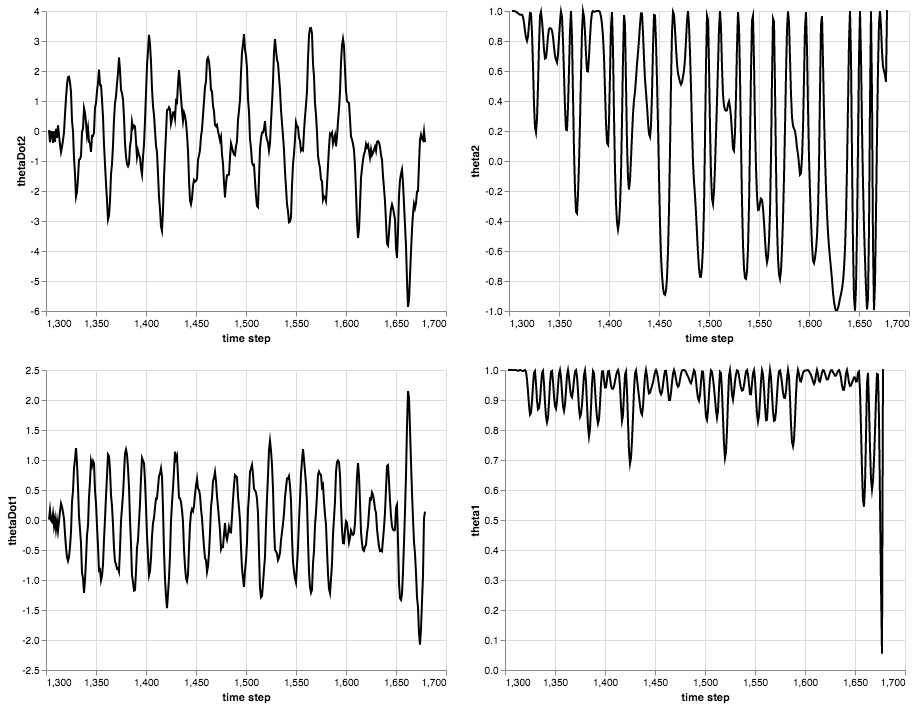

In [9]:
figs = []
start_time = 1303
end_time = 1680
for observable_col in problem._target_column_observation_names:
    ground_truth = X_ds.to_dataframe().reset_index().reset_index()
    line_gt = alt.Chart(ground_truth[start_time:end_time]).mark_line(color='black').encode(
        x=alt.X('index:Q', title='time step'),
        y=alt.Y(observable_col + ':Q', scale=alt.Scale(zero=False)),
    )
    fig = line_gt
    figs.append(fig)
alt.vconcat(alt.hconcat(*figs[:2]), alt.hconcat(*figs[2:]))

## The pipeline: what you need to develop

For submitting at the challenge site, you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor` in `ts_feature_extractor.py`, which will be used to extract features for representing the system state at time $t$. 
* the class `GenerativeRegressor` in `generative_regressor.py` to predict the distribution of the six system variables at time $t+1$ from the features returned by the feature extractor.

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/ts_feature_extractor.py`](submissions/starting_kit/ts_feature_extractor.py). It receives an xarray Dataset `X_ds` defined at the beginning of the notebook. It should produce a pandas DataFrame containing the extracted features, which will then be used for regression.  

Be careful not to use any information from the future (`X_ds[t + 1:]`) when constructing `X_df[t]`. We have implemented a check for that in the training workflow, but any attempt to purposefully work around those checks may lead to disqualification from the challenge.

The following simple feature extractor in the starting kit simply makes $s_t = (o_t, a_t)$.

In [9]:
# %load submissions/starting_kit/ts_feature_extractor.py
class FeatureExtractor():
    def __init__(self, restart_name):
        """
        Parameters
        ----------
        restart_name : str
            The name of the 0/1 column indicating restarts in the time series.
        """
        self.restart_name = restart_name

    def transform(self, X_ds):
        """Transform time series into list of states.
        We simply use the observables at time t as the state.
        Be careful not to use any information from the future (X_ds[t + 1:])
        when constructing X_df[t].
        Parameters
        ----------
        X_ds : xarray.Dataset
            The raw time series.
        Return
        ------
        X_df : pandas Dataframe
            The list of states.
        """
        X_df = X_ds.to_dataframe()
        # Since we do not use the restart information in our regressor, we
        # remove it
        restart = X_df[self.restart_name].values
        X_df = X_df.drop(columns=self.restart_name)
        return X_df

### Generative regressor

The generative regressor follows a classical scikit-learn regressor template. It should be saved in the file [`submissions/starting_kit/generative_regressor.py`](submissions/starting_kit/generative_regressor.py). 

The `__init__` function receives two parameters that you can use in `fit` and `predict`. `max_dists` is the maximum number of components in the mixture distribution, and `target_dim` is the index of the dimension being predicted ($j$ in the introduction, $j \in [0,5]$). 

The `fit` function receives the input array `X_array` and the ground truth target numpy array `y_array`. The number of rows is the number of time steps. The columns of `X_array` are the features you extracted in the feature extractor followed by the `target_dim` (= $j-1$) system observables $\big(o^1_{t+1}, \ldots, o^{j-1}_{t+1}\big)$. The number of columns in `y_array` is one representing the target $o^j_{t+1}$.

The particular regressor learns a classical linear regressor and saves the standard deviation of the residuals. 

The `predict` function receives the input test array `X_array`, the format is the same as in `fit`. It then constructs the one-dimensional density for its target $o^j_{t+1}$ ($j=$ `target_dim` $+ 1$). As in the feature extractor, be careful not to use any information from the future (`X_array[t + 1:]`) when constructing the output.

The particular regressor constructs a single Gaussian (so $w_1 = 1$), centered by the output of the linear regressor, with a fixed sigma (the standard deviation of the residuals in the training set). The type (code) of the Gaussian is 0.

We have other component types implemented in [rampwf.utils.distributions_dict](https://github.com/paris-saclay-cds/ramp-workflow/blob/generative_regression_clean/rampwf/utils/generative_regression.py): uniform (1) and beta (2). If you would like to use other component types, either let us know which one, or (better) implement it and make a pull request into the [generative_regression_clean](https://github.com/paris-saclay-cds/ramp-workflow/tree/generative_regression_clean) branch on ramp-workflow. After checks we will merge the PR, install it on the server and make an announcement in Slack to make it available to everybody. You can then submit your solution with the new kernel types.

In [ ]:
# %load submissions/starting_kit/generative_regressor.py
from sklearn.base import BaseEstimator
import numpy as np
from sklearn.linear_model import LinearRegression


class GenerativeRegressor(BaseEstimator):
    def __init__(self, max_dists, target_dim):
        """
        Parameters
        ----------
        max_dists : int
            The maximum number of distributions (kernels) in the mixture.
        target_dim : int
            The index of the target column to be predicted [0..d-1]
        """
        pass

    def fit(self, X_array, y_array):
        """Linear regression + residual sigma.
        
        Parameters
        ----------
        X_array : numpy array
            The input array. The features extracted by the feature extractor,
            plus `target_dim` system observables from time step t+1.
        y_array : numpy array
            The ground truth array (system observable j=`target_dim` + 1
            at time step t+1: o^j_{t+1}).
        """
        self.reg = LinearRegression()
        self.reg.fit(X_array, y_array)
        y_pred = self.reg.predict(X_array)
        y_pred = np.array([y_pred]).reshape(-1, 1)
        residuals = y_array - y_pred
        # Estimate a single sigma from residual variance
        self.sigma = np.sqrt(
            (1 / (X_array.shape[0] - 1)) * np.sum(residuals ** 2))

    def predict(self, X_array):
        """Construct a conditional mixture distribution.

        Be careful not to use any information from the future
        (X_array[t + 1:]) when constructing the output.

        Parameters
        ----------
        X_array : numpy array
            The input array. The features extracted by the feature extractor,
            plus `target_dim` system observables from time step t+1.

        Return
        ------
        weights : np.array of float
            discrete probabilities of each component of the mixture
        types : np.array of int
            integer codes referring to component types
            see rampwf.utils.distributions_dict
        params : np.array of float tuples
            parameters for each component in the mixture
        """
        types = np.array([[0], ] * len(X_array))

        # Normal
        y_pred = self.reg.predict(X_array)
        sigmas = np.array([self.sigma] * len(X_array))
        sigmas = sigmas[:, np.newaxis]
        params = np.concatenate((y_pred, sigmas), axis=1)
        weights = np.array([[1.0], ] * len(X_array))
        return weights, types, params

## Training and scoring

You can train and test the starting kit in a terminal or here in the notebook using the `ramp test` script. By default it tests the starting kit, if you would like to test another submission, you can specify it with `--submission <name>` where `<name>` is what you named the directory in [`submissions/`](submissions).

We are using as many cross validation folds as episodes in the training file (number of restarts + 1). With $N$ episodes, we train on $N-1$ in each fold and test on the remaining one. The number of folds in the training set is 2. The training script prints the episode bounds and the fold indices, then trains, validates (on the validation fold), and tests (on the test set loaded by `problem.get_test_data{}`). Finally the mean and bagged scores are displayed. 

On the server, the public leaderboard will display your bagged validation score during the competition. Your final ranking will be determined by the bagged test score. The data is  different in this public starting kit and on the server. We use different physics to make reverse engineering harder.

In [7]:
!ramp test

Testing Acrobot system identification
Reading train and test files from ./data ...
Reading cv ...
episode bounds: [0, 333, 1303, 1678, 2093, 2532, 3288, 4999]
CV fold 0: train 333..4998,  valid 0..332, 
CV fold 1: train 0..332, 1303..4998,  valid 333..1302, 
CV fold 2: train 0..1302, 1678..4998,  valid 1303..1677, 
CV fold 3: train 0..1677, 2093..4998,  valid 1678..2092, 
CV fold 4: train 0..2092, 2532..4998,  valid 2093..2531, 
CV fold 5: train 0..2531, 3288..4998,  valid 2532..3287, 
CV fold 6: train 0..3287,  valid 3288..4998, 
Training submissions/starting_kit ...
CV fold 0
	score  likelihood_ratio      time
	train              3.46  0.097224
	valid              2.41  0.165595
	test               2.67  0.052297
CV fold 1
	score  likelihood_ratio      time
	train              3.63  0.022223
	valid              2.78  0.058459
	test               2.76  0.058863
CV fold 2
	score  likelihood_ratio      time
	train              3.58  0.028962
	valid              1.91  0.054981
	test     

### What does `ramp test` do? Step-by-step.

First, let's load the fold indices of the first fold.

In [41]:
get_cv = problem.get_cv
train_is, valid_is = list(get_cv(X_ds, y_array))[0]

restarts: [0, 2795, 4999]
CV fold 0: train 2795..4998,  valid 0..2794, 
CV fold 1: train 0..2794,  valid 2795..4998, 


Now load the workflow and train the model.

In [42]:
workflow = problem.workflow
fe, reg = workflow.train_submission(
    'submissions/starting_kit', X_ds, y_array, train_is)

Now test the trained model, first on the full training data then on the test data.

In [43]:
y_preds = workflow.test_submission((fe, reg), X_ds)
X_test_ds, y_test_array = problem.get_test_data()
y_test_preds = workflow.test_submission((fe, reg), X_test_ds)

Finally, load the score type (metrics) and compute the training, validation, and test scores.

In [44]:
score_type = problem.score_types[0]
train_score = score_type(y_array[train_is], y_preds[train_is])
valid_score = score_type(y_array[valid_is], y_preds[valid_is])
test_score = score_type(y_test_array, y_test_preds)
print(train_score, valid_score, test_score)

4.737093873592116 4.2231261108041425 4.33189834477496


## Submitting to the hackathon server

Once you found a good feature extractor and classifier, you can submit them to the hackathon server. First, if it is your first time using RAMP, sign up, otherwise log in. The system sends you a mail where you can validate your signup, then the site admins will validate it. Once this is done, click on the "Huawei Hackathon" event under the "Acrobot system identification" problem, and sign up.

Once you are signed up, you can go to your sandbox (menu at the left) and copy-paste  [`ts_feature_extractor.py`](/submissions/starting_kit/ts_feature_extractor.py) and [`generative_regressor.py`](/submissions/starting_kit/generative_regressor.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in my submissions. Once it is trained, your submission shows up on the leaderboard.

If there is an error, it will show up in the "Failed submissions" table in my submissions. You can click on the error to see the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission. This will be especially interesting in the collaborative phase (after the competition is over) when you can look at and reuse other solutions.

The data set we use at the backend is different from what you find in the starting kit, so the score may be different.

# Other models in the starting kit

You can also keep several other submissions in your work directory [`submissions`](/submissions). [`generative_rf`](/submissions/generative_rf) uses a feature extractor that concatenates to $o_t$ the mean of the observables of the last time steps, handling restarts intelligently (not using the observables of the previous episode).

In [ ]:
# %load submissions/generative_rf/ts_feature_extractor.py
import pandas as pd
import numpy as np


class FeatureExtractor():
    def __init__(self, restart_name):
        """
        Parameters
        ----------
        restart_name : str
            The name of the 0/1 column indicating restarts in the time series.
        """
        self.restart_name = restart_name
        pass

    def transform(self, X_df_raw):
        """Transform time series into list of states.
        We use the observables at time t as the state, concatenated to the mean 
        of the last ten time steps, handling restarts.
        
        Be careful not to use any information from the future (X_ds[t + 1:])
        when constructing X_df[t].
        Parameters
        ----------
        X_ds : xarray.Dataset
            The raw time series.
        Return
        ------
        X_df : pandas Dataframe

        """
        X_df = X_df_raw.to_dataframe()

        restart = X_df[self.restart_name].values

        # Since we do not use the restart information in our regressor, we have
        # to remove it
        X_df = X_df.drop(columns=self.restart_name)

        tail = 10
        result_array = []
        curr_tail = tail
        for i in range(len(X_df)):
            if restart[i] == 1:
                # If we encounter a restart, tail is set to 0
                curr_tail = 0
            elif curr_tail < tail:
                # And it goes back up to it's normal length if no other restarts
                curr_tail += 1

            X_temp = X_df.iloc[
                    [idx for idx in range(i - curr_tail, i + 1) if idx >= 0]
                                ].mean(axis=0)
            result_array.append(X_temp)
        result_array = np.vstack(result_array)
        additional_dim = pd.DataFrame(result_array)

        new_names = [item + "_engineered" for item in list(X_df_raw.keys())]
        additional_dim.rename(
            columns={i: item for i, item in enumerate(new_names)}, inplace=True)

        date = X_df.index.copy()
        X_df.reset_index(drop=True, inplace=True)
        X_array = pd.concat([X_df, additional_dim], axis=1)

        X_array.set_index(date, inplace=True)

        # We return a dataframe with additional features (with no clashing names)
        # based on previous values' mean, being mindful about restarts

        return X_array

In [ ]:
# %load submissions/generative_rf/generative_regressor.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from rampwf.hyperopt import Hyperparameter
 
 
# RAMP START HYPERPARAMETERS
#sigma_multiplier = Hyperparameter(
#    dtype='float', default=0.2, values=[
#            0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3])
#n_estimators = Hyperparameter(
#    dtype='int', default=200, values=[30, 50, 100, 200, 300])
#max_leaf_nodes = Hyperparameter(
#    dtype='int', default=5000, values=[1000, 2000, 5000, 10000])
# RAMP END HYPERPARAMETERS                                            
 
method_proba = 'estimate_sigma'
EPSILON =1e-8
 
 
class GenerativeRegressor(BaseEstimator):
    def __init__(self, max_dists, model_index):
        self.max_dists = min(100, max_dists) 
        self.clf = BaggingRegressor(
            base_estimator=DecisionTreeRegressor(
                max_leaf_nodes=5000),
            n_estimators=self.max_dists-1, # The last dist is uniform
            max_samples=0.2,
        )
        self.sigma = None
        self.a = None
        self.b = None
 
    def fit(self, X, y):
        self.clf.fit(X, y.ravel())
        yGuess = self.clf.predict(X)
        yGuess = np.array([yGuess]).reshape(-1, 1)
        error = y - yGuess
        self.sigma = np.sqrt((1 / X.shape[0]) * np.sum(error ** 2))
        self.a = np.min(y) - 10
        self.b = np.max(y) + 10
 
    def predict(self, X):
 
        # We give every distribution the same weight
        eps = 10 ** -10
        w = (1.0 - EPSILON)/(self.max_dists - 1) 
        weights = np.stack([[w] * len(X)
                            for _ in range(self.max_dists)],
                           axis=1)
        weights[:, 0] = EPSILON
        # The first generative regressors are gaussian, the last is uniform
        types = np.zeros(self.max_dists)
        types[-1] = 1
        types = np.array([types] * len(X))
 
        # Gaussians
        mus = np.zeros((len(X), len(self.clf.estimators_),))
        for i, est in enumerate(self.clf.estimators_):
            mus[:, i] = est.predict(X)
 
        if method_proba == 'estimate_sigma':
            # Third method, uses the information from the trees to estimate
            # sigma and estimate gaussian noise around outpus
            sigma = mus.std(axis=1)
            sigma = np.clip(sigma, EPSILON, None, out=sigma)
            sigmas = np.stack([sigma for _ in range(len(self.clf.estimators_))],
                              axis=1)
 
        elif method_proba == 'standard':
            sigmas = np.stack([[self.sigma] * len(X)
                               for _ in range(len(self.clf.estimators_))],
                              axis=1)
        else:
            sigmas = np.nan
 
        #sigmas *= float(sigma_multiplier)
        sigmas /= float(np.sqrt(self.max_dists - 1))
 
        # We put each mu next to its sigma
        params_normal = np.empty((len(X), len(self.clf.estimators_)*2))
        params_normal[:, 0::2] = mus
        params_normal[:, 1::2] = sigmas
 
        # Uniform
        a_array = np.array([self.a] * len(X))
        b_array = np.array([self.b] * len(X))
        params_uniform = np.stack((a_array, b_array), axis=1)
 
        # We concatenate the params
        params = np.concatenate((params_normal, params_uniform), axis=1)
        return weights, types, params


## More information

You can find more information in the [ramp-workflow documentation](https://paris-saclay-cds.github.io/ramp-workflow).

## Contact

Use Slack to contact us.